In [5]:
!pip install PyWavelets

In [1]:
import torch

In [2]:
import argparse
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19

In [3]:
class VGG19(torch.nn.Module):
    def __init__(self, device='cpu'):
        super(VGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps

In [4]:
class Fusion:
    def __init__(self, input):
        """
        Class Fusion constructor

        Instance Variables:
            self.images: input images
            self.model: CNN model, default=vgg19
            self.device: either 'cuda' or 'cpu'
        """
        self.input_images = input
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):
        """
        A top level method which fuse self.images
        """
        # Convert all images to YCbCr format
        self.normalized_images = [-1 for img in self.input_images]
        self.YCbCr_images = [-1 for img in self.input_images]
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx] = self._RGB_to_YCbCr(img)
                self.normalized_images[idx] = self.YCbCr_images[idx][:, :, 0]
            else:
                self.normalized_images[idx] = img / 255.
        # Transfer all images to PyTorch tensors
        self._tranfer_to_tensor()
        # Perform fuse strategy
        fused_img = self._fuse()[:, :, 0]
        # Reconstruct fused image given rgb input images
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx][:, :, 0] = fused_img
                fused_img = self._YCbCr_to_RGB(self.YCbCr_images[idx])
                fused_img = np.clip(fused_img, 0, 1)

        return (fused_img * 255).astype(np.uint8)
        # return fused_img

    def _fuse(self):
        """
        Perform fusion algorithm
        """
        with torch.no_grad():

            imgs_sum_maps = [-1 for tensor_img in self.images_to_tensors]
            for idx, tensor_img in enumerate(self.images_to_tensors):
                imgs_sum_maps[idx] = []
                feature_maps = self.model(tensor_img)
                for feature_map in feature_maps:
                    sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                    imgs_sum_maps[idx].append(sum_map)

            max_fusion = None
            for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=1)
                weights = self._softmax(F.interpolate(features,
                                        size=self.images_to_tensors[0].shape[2:]))
                weights = F.interpolate(weights,
                                        size=self.images_to_tensors[0].shape[2:])
                current_fusion = torch.zeros(self.images_to_tensors[0].shape)
                for idx, tensor_img in enumerate(self.images_to_tensors):
                    current_fusion += tensor_img * weights[:,idx]
                if max_fusion is None:
                    max_fusion = current_fusion
                else:
                    max_fusion = torch.max(max_fusion, current_fusion)

            output = np.squeeze(max_fusion.cpu().numpy())
            if output.ndim == 3:
                output = np.transpose(output, (1, 2, 0))
            return output
        
        
    def _RGB_to_YCbCr(self, img_RGB):
            """
            A private method which converts an RGB image to YCrCb format
            """
            img_RGB = img_RGB.astype(np.float32) / 255.
            return cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)

    def _YCbCr_to_RGB(self, img_YCbCr):
            """
            A private method which converts a YCrCb image to RGB format
            """
            img_YCbCr = img_YCbCr.astype(np.float32)
            return cv2.cvtColor(img_YCbCr, cv2.COLOR_YCrCb2RGB)

    def _is_gray(self, img):
            """
            A private method which returns True if image is gray, otherwise False
            """
            if len(img.shape) < 3:
                return True
            if img.shape[2] == 1:
                return True
            b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
            if (b == g).all() and (b == r).all():
                return True
            return False

    def _softmax(self, tensor):
            """
            A private method which compute softmax ouput of a given tensor
            """
            tensor = torch.exp(tensor)
            tensor = tensor / tensor.sum(dim=1, keepdim=True)
            return tensor

    def _tranfer_to_tensor(self):
            """
            A private method to transfer all input images to PyTorch tensors
            """
            self.images_to_tensors = []
            for image in self.normalized_images:
                np_input = image.astype(np.float32)
                if np_input.ndim == 2:
                    np_input = np.repeat(np_input[None, None], 3, axis=1)
                else:
                    np_input = np.transpose(np_input, (2, 0, 1))[None]
                if self.device == "cuda":
                    self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
                else:
                    self.images_to_tensors.append(torch.from_numpy(np_input)) 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

In [ ]:
# bone = CT, brain = MRI 바뀜~

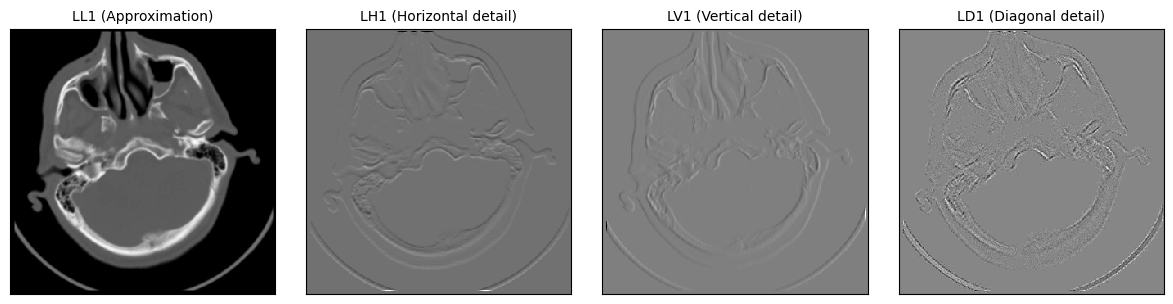

In [79]:
# Load MRI image
mri_image = cv2.imread('Patients_CT/049/bone/10.jpg')
mri_image = cv2.cvtColor(mri_image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['LL1 (Approximation)', 'LH1 (Horizontal detail)',
          'LV1 (Vertical detail)', 'LD1 (Diagonal detail)']
coeffs2 = pywt.dwt2(mri_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='Patients_CT/049/mri_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

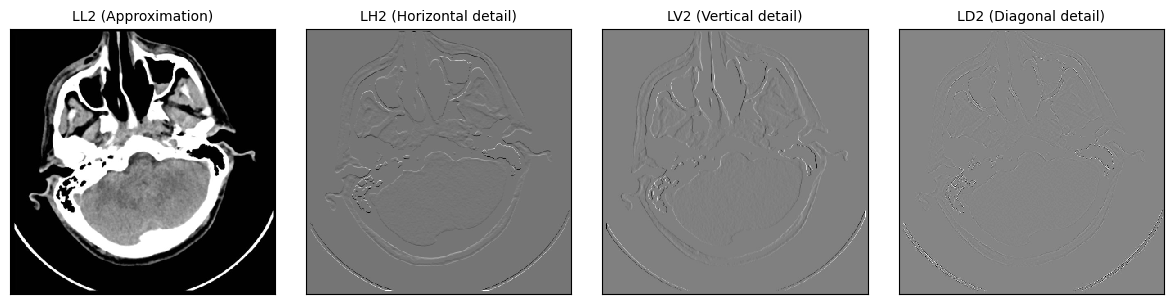

In [80]:
# Load CT Image
ct_image = cv2.imread('Patients_CT/049/brain/10.jpg')
ct_image = cv2.cvtColor(ct_image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['LL2 (Approximation)', 'LH2 (Horizontal detail)',
          'LV2 (Vertical detail)', 'LD2 (Diagonal detail)']
coeffs2 = pywt.dwt2(ct_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='Patients_CT/049/ct_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [28]:
LL.shape

(325, 325)

In [22]:

cv2.imshow('Image', HH)

# 사용자가 키보드의 아무 키나 누를 때까지 대기합니다.
cv2.waitKey(0)

# 모든 윈도우를 닫습니다.
cv2.destroyAllWindows()

In [30]:
# Calling the methods for Siamese on LL Images
input_images = []
mri = cv2.imread('Patients_CT/049/mri_0.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('Patients_CT/049/ct_0.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('Patients_CT/049/fusion_0.jpg', fusion_img)

C:\Users\jonghyun\anaconda3\envs\bmes\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jonghyun\anaconda3\envs\bmes\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\jonghyun/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:50<00:00, 11.3MB/s]


True

In [53]:
def Transform_MRI_image(image_dir, image_name, save_dir):

# Load MRI image
    mri_image = cv2.imread(image_dir + '/' + image_name + '.jpg')
    mri_image = cv2.cvtColor(mri_image, cv2.COLOR_BGR2GRAY)

    coeffs2 = pywt.dwt2(mri_image, 'haar')

    LL, (LH, HL, HH) = coeffs2

    for i, a in enumerate([LL, LH, HL, HH]):        
        path = save_dir + '/' + image_name + '_mri_'+str(i)+'.jpg'
        cv2.imwrite(path,a)


In [54]:
def Transform_CT_image(image_dir, image_name, save_dir):

# Load CT Image
    ct_image = cv2.imread(image_dir + '/' + image_name + '.jpg')
    ct_image = cv2.cvtColor(ct_image, cv2.COLOR_BGR2GRAY)

    coeffs2 = pywt.dwt2(ct_image, 'haar')

    LL, (LH, HL, HH) = coeffs2

    for i, a in enumerate([LL, LH, HL, HH]):
        path = save_dir + '/' + image_name + '_ct_'+str(i)+'.jpg'
        cv2.imwrite(path,a)


In [60]:
def Fuse_images(save_dir, current_dir, image_name):
    # Calling the methods for Siamese on LH Images
    for i in range(4):
        input_images = []
        mri = cv2.imread(save_dir + '/' + image_name + '_mri_' + str(i) + '.jpg')
        mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

        ct = cv2.imread(save_dir + '/' + image_name + '_ct_' + str(i) + '.jpg')
        ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

        input_images.append(mri)
        input_images.append(ct)

        # Compute fusion image
        FU = Fusion(input_images)
        fusion_img = FU.fuse()
        # Write fusion image
        cv2.imwrite(save_dir + '/' + image_name + '_fusion_' + str(i) + '.jpg', fusion_img)
        
    fusion_0 = cv2.imread(save_dir + '/' + image_name + '_fusion_0' + '.jpg')
    fusion_0 = cv2.cvtColor(fusion_0, cv2.COLOR_BGR2GRAY)

    fusion_1 = cv2.imread(save_dir + '/' + image_name + '_fusion_1' + '.jpg')
    fusion_1 = cv2.cvtColor(fusion_1, cv2.COLOR_BGR2GRAY)

    fusion_2 = cv2.imread(save_dir + '/' + image_name + '_fusion_2' + '.jpg')
    fusion_2 = cv2.cvtColor(fusion_2, cv2.COLOR_BGR2GRAY)

    fusion_3 = cv2.imread(save_dir + '/' + image_name + '_fusion_3' + '.jpg')
    fusion_3 = cv2.cvtColor(fusion_3, cv2.COLOR_BGR2GRAY)

    coeffs=(fusion_0,(fusion_1,fusion_2,fusion_3))
    
    fusion=pywt.idwt2(coeffs,'haar')
    cv2.imwrite(current_dir + '/' + image_name + '_final_fusion.jpg',fusion)

In [61]:
## testing

current_dir = os.path.join("Patients_CT", "049")
os.makedirs(os.path.join(current_dir, "band_fusion"), exist_ok=True)
for slice_numbers in os.listdir(os.path.join(current_dir, "bone")):
    bone_image_dir = os.path.join(current_dir, "bone")
    brain_image_dir = os.path.join(current_dir, "brain")
    image_name = slice_numbers[:-4]
    print("image name : ", image_name)
    save_dir = os.path.join(current_dir, "band_fusion")

    Transform_MRI_image(bone_image_dir, image_name, save_dir)
    Transform_CT_image(brain_image_dir, image_name, save_dir)
    Fuse_images(save_dir, current_dir, image_name)

image name :  1
image name :  10
image name :  11
image name :  12
image name :  13


KeyboardInterrupt: 

In [63]:
mother_dir = "Patients_CT"
for files in os.listdir(mother_dir):
    print("file : ", files)
    current_dir = os.path.join(mother_dir, files)
    os.makedirs(os.path.join(current_dir, "band_fusion"), exist_ok=True)
    for slice_numbers in os.listdir(os.path.join(current_dir, "bone")):
        bone_image_dir = os.path.join(current_dir, "bone")
        brain_image_dir = os.path.join(current_dir, "brain")
        image_name = slice_numbers[:-4]
        print("image name : ", image_name)
        save_dir = os.path.join(current_dir, "band_fusion")

        Transform_MRI_image(bone_image_dir, image_name, save_dir)
        Transform_CT_image(brain_image_dir, image_name, save_dir)
        Fuse_images(save_dir, current_dir, image_name)
        


file :  049
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  27
image name :  28
image name :  29
image name :  3
image name :  30
image name :  31
image name :  32
image name :  33
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  050
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  3
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image n

image name :  25
image name :  26
image name :  3
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  065
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  27
image name :  28
image name :  29
image name :  3
image name :  30
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  066
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image na

image name :  23
image name :  24
image name :  25
image name :  26
image name :  27
image name :  28
image name :  29
image name :  3
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  081
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  27
image name :  28
image name :  29
image name :  3
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  082
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image na

image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  27
image name :  28
image name :  29
image name :  3
image name :  30
image name :  31
image name :  32
image name :  33
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  097
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  27
image name :  28
image name :  29
image name :  3
image name :  30
image name :  31
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  098
image name :  1
image name :  10
image na

image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  3
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  113
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  27
image name :  28
image name :  3
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  114
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image na

image name :  28
image name :  29
image name :  3
image name :  30
image name :  31
image name :  32
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  128
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image name :  26
image name :  27
image name :  28
image name :  3
image name :  4
image name :  5
image name :  6
image name :  7
image name :  8
image name :  9
file :  129
image name :  1
image name :  10
image name :  11
image name :  12
image name :  13
image name :  14
image name :  15
image name :  16
image name :  17
image name :  18
image name :  19
image name :  2
image name :  20
image name :  21
image name :  22
image name :  23
image name :  24
image name :  25
image na

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'Patients_CT\\49\\bone'

# Segmentation

In [67]:
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater

In [69]:
def ShowImage(title,img,ctype):
    plt.figure(figsize=(10, 10))
    if ctype=='bgr':
        b,g,r = cv2.split(img)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb
        plt.imshow(rgb_img)
    elif ctype=='hsv':
        rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
        plt.imshow(rgb)
    elif ctype=='gray':
        plt.imshow(img,cmap='gray')
    elif ctype=='rgb':
        plt.imshow(img)
    else:
        raise Exception("Unknown colour type")
    plt.axis('off')
    plt.title(title)
    plt.show()

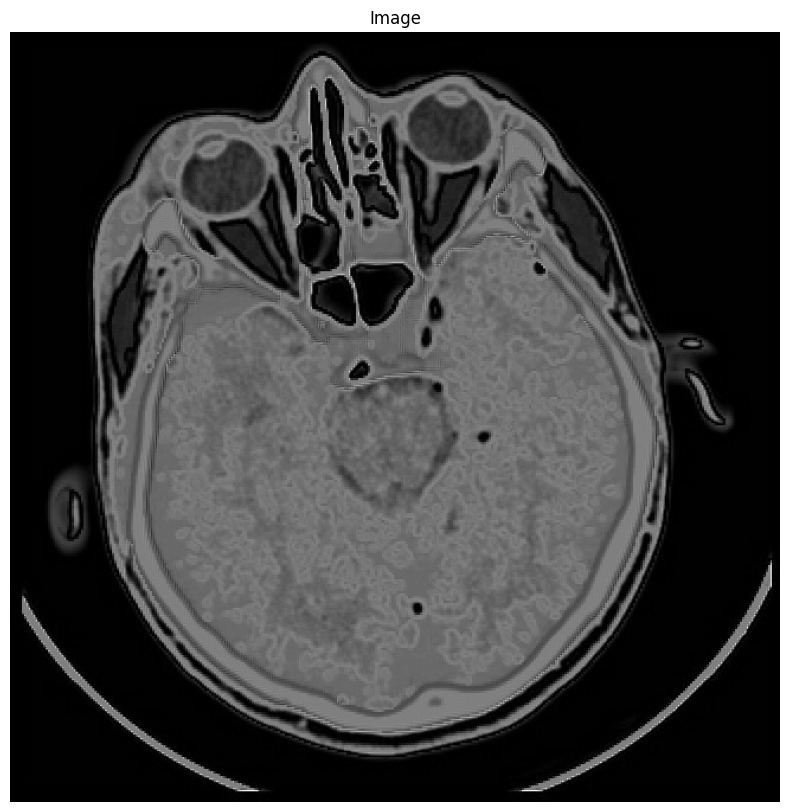

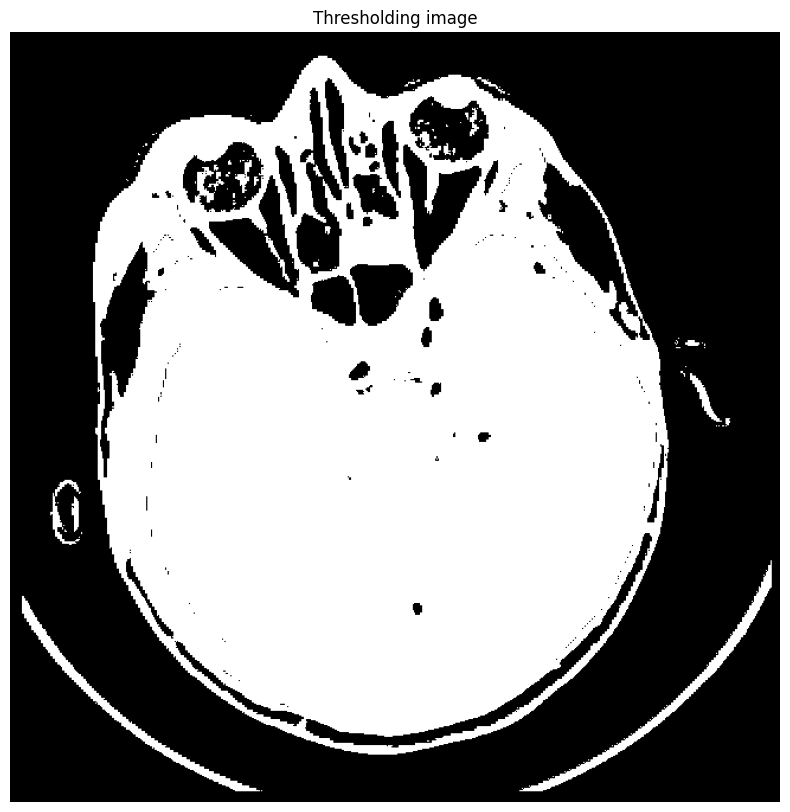

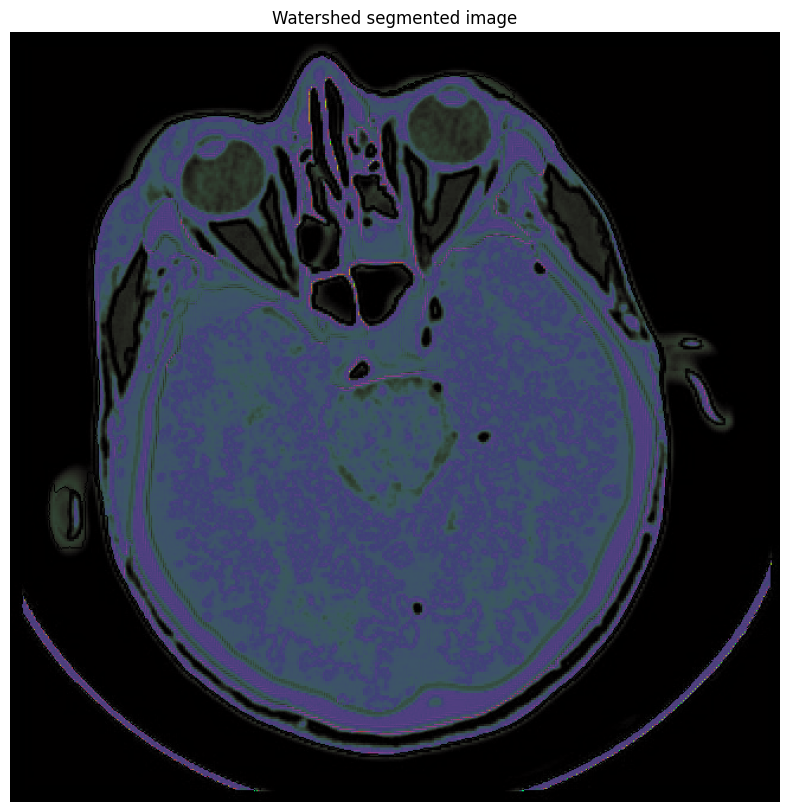

In [71]:
imdir = os.path.join("Patients_CT", "049", "15_final_fusion.jpg")
img = cv2.imread(imdir)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Image',gray,'gray')

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Thresholding image',thresh,'gray')

ret, markers = cv2.connectedComponents(thresh)

marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
brain_mask = markers==largest_component

brain_out = img.copy()
brain_out[brain_mask==False] = (0,0,0)

img = cv2.imread(imdir)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

im1 = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
# save_to_path="jpg/segmented.jpg"
# cv2.imwrite(save_to_path, im1)
ShowImage('Watershed segmented image',im1,'gray')

In [74]:
gray.shape

(650, 650)